/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/openml/tasks/functions.py:372: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  warnings.warn(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/openml/datasets/functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
/tmp/ipykernel_2279777/2225661385.py:13: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure yo

encoders None


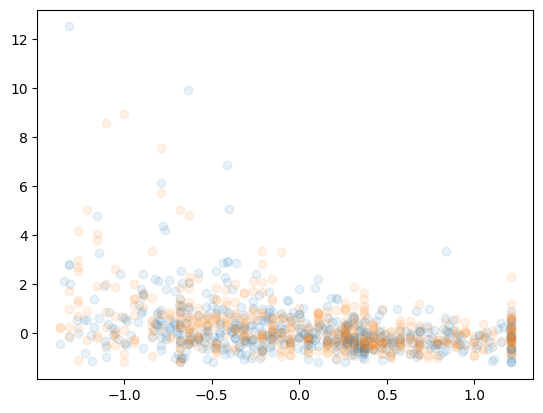

In [5]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import GenericDataLoader
from sklearn.preprocessing import RobustScaler
from synthcity_addons import generators
import numpy as np
#X, _ = make_moons(n_samples=5000, noise=0.1)
import openml

task_id = 361078#361110#361078
task = openml.tasks.get_task(task_id)
X, y = task.get_X_and_y()
# make moons
#X, y = make_moons(n_samples=10_000, noise=0.1)
# shuffle
indices = np.random.permutation(X.shape[0])
X = X[indices]
y = y[indices]

#normalize
X = RobustScaler().fit_transform(X)

#X = X[:, (0, 1)]

loader = GenericDataLoader(X)


device = "cuda:0"

# syn_model = Plugins().get("tabpfn_points", n_batches=100, lr=0.02, store_intermediate_data=True, initialization_strategy="smote",
#                            store_animation_path="animation.mp4", device=device, use_kmeans_tabpfn=True, n_clusters_kmeans_tabpfn=5, n_ensembles=1,
#                           loss="adjusted", noise_std=1)
#syn_model = Plugins().get("ddpm")
#syn_model = tabpfn_points_plugin(n_batches=2, lr=0.1, store_intermediate_data=True, initialization_strategy="smote", store_animation_path="animation.mp4")
#tabpfn_output_proba, X_false_train, y_test = syn_model.fit(loader)
syn_model = Plugins().get("smote")
syn_model.fit(loader)

false_data = syn_model.generate(512).numpy()
plt.scatter(false_data[:, 1], false_data[:, 2], alpha=0.1)
plt.scatter(X[:512, 1], X[:512, 2], alpha=0.1)
#plt.title(method)


In [6]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from tabpfn import TabPFNClassifier as TabPFNClassifier_old
from tabpfn_client import TabPFNClassifier


accuracies_tabpfn_client = []
accuracies_tabpfn_old = []
accuracies_gbdt = []
for i in range(3):
    X, y = task.get_X_and_y()
    #X, y = make_moons(n_samples=3_000, noise=0.2)
    # shuffle
    rng = np.random.RandomState(i)
    indices = rng.permutation(X.shape[0])
    X = X[indices]
    y = y[indices]

    #normalize
    X = RobustScaler().fit_transform(X)

    #X = X[:, (1, 2)]

    loader = GenericDataLoader(X)
    syn_model = Plugins().get("smote")
    syn_model.fit(loader)

    X_false = syn_model.generate(512).numpy()
    #X_true = X[-len(X_false):, :2]
    X_true = X[-len(X_false):, :]

    print("true", X_true.shape)
    print("false", X_false.shape)
    # plot
    # plt.scatter(X_true[:, 0], X_true[:, 1], alpha=0.1)
    # plt.scatter(X_false[:, 0], X_false[:, 1], alpha=0.1)

    X_combined = np.vstack((X_true, X_false))
    y_combined = np.hstack((np.ones(X_true.shape[0]), np.zeros(X_false.shape[0])))

    X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

    clf = GradientBoostingClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of GradientBoostingClassifier: {accuracy:.4f}")
    accuracies_gbdt.append(accuracy)

    clf_tabpfn = TabPFNClassifier_old()
    clf_tabpfn.fit(X_train, y_train, overwrite_warning=True)
    y_pred_tabpfn = clf_tabpfn.predict(X_test)
    accuracy_tabpfn = accuracy_score(y_test, y_pred_tabpfn)
    print(f"Accuracy of TabPFNClassifier old: {accuracy_tabpfn:.4f}")
    accuracies_tabpfn_old.append(accuracy_tabpfn)

    clf_tabpfn_client = TabPFNClassifier(n_estimators=16)
    clf_tabpfn_client.fit(X_train, y_train)
    y_pred_tabpfn_client = clf_tabpfn_client.predict(X_test)
    accuracy_tabpfn_client = accuracy_score(y_test, y_pred_tabpfn_client)
    print(f"Accuracy of TabPFNClassifier: {accuracy_tabpfn_client:.4f}")
    accuracies_tabpfn_client.append(accuracy_tabpfn_client)

print(np.mean(accuracies_tabpfn_client))
print(np.mean(accuracies_tabpfn_old))
print(np.mean(accuracies_gbdt))



/tmp/ipykernel_2279777/954131455.py:15: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y = task.get_X_and_y()
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/openml/datasets/functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/openml/tasks/task.py:276: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to e

encoders None
true (512, 8)
false (512, 8)
Accuracy of GradientBoostingClassifier: 0.4732
NORMALIZING
NORMALIZING


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Accuracy of TabPFNClassifier old: 0.4634


RuntimeError: Fail to call predict with error: {'detail': 'Prediction API Limit Reached! Currently, we only allow 100 predictions per day for your account. Please try again after 2024-10-16 00:00:00 UTC!'}

In [16]:
from tabpfn_client.constants import CACHE_DIR

In [17]:
CACHE_DIR

Path('/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/tabpfn_client/.tabpfn')

In [14]:
reset()
init()

In [14]:
service = ServiceClient()
#service.login(email="leo.grileo@gmail.com", password="K8VuQ7ST93b75Bc@")
service.logout()

AttributeError: 'ServiceClient' object has no attribute 'logout'

In [14]:
print(np.mean(accuracies_tabpfn_client), np.median(accuracies_tabpfn_client))
print(np.mean(accuracies_gbdt), np.median(accuracies_gbdt))


0.5026829268292683 0.501219512195122
0.5495121951219512 0.5414634146341464
